In [ ]:
# install requirements for Colab, might need to restart runtime after running this cell
!pip install robustness
!pip install ftfy
!pip install tensorboardx==1.8
!pip install cox
!pip install regex
!pip install tensorflow-gpu
!pip install tensorflow_hub
!pip install statsmodels
!pip install torchvision==0.8.2
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
!git clone https://github.com/ind1010/EditingClassifiers
%cd EditingClassifiers/

In [ ]:
# detectron2 imports
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# editing classifier imports
import sys, os, warnings
from argparse import Namespace
warnings.filterwarnings("ignore")

import torch as ch
from torchvision import transforms
import numpy as np
from PIL import Image
from tqdm import tqdm

from helpers import classifier_helpers
import helpers.data_helpers as dh
import helpers.context_helpers as coh
import helpers.rewrite_helpers as rh
import helpers.vis_helpers as vh
from helpers.instance_metrics import compute_metrics

%matplotlib inline

In [ ]:
# change as needed
PATH_TO_KEYS = './samples/keys/keys_C'
PATH_TO_VALUES = './samples/values/values_nonarchtoredmud_C'

## Load model

In [ ]:
# inference set-up
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = "./checkpoints/"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "original_model.pth")
predictor = DefaultPredictor(cfg)

In [ ]:
im = cv2.imread('./samples/images/original_C.tif')
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                metadata=MetadataCatalog.get("train"), 
                scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(cv2.resize(out.get_image()[:, :, ::-1], (1200,800)))

In [ ]:
im2 = cv2.imread('./samples/images/inpaintednonarch_C.tif')
outputs2 = predictor(im2)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im2[:, :, ::-1],
                metadata=MetadataCatalog.get("train"), 
                scale=0.5)
out2 = v.draw_instance_predictions(outputs2["instances"].to("cpu"))
cv2_imshow(cv2.resize(out2.get_image()[:, :, ::-1], (1200,800)))

## Load base dataset and vehicles-on-snow data

Train exemplars


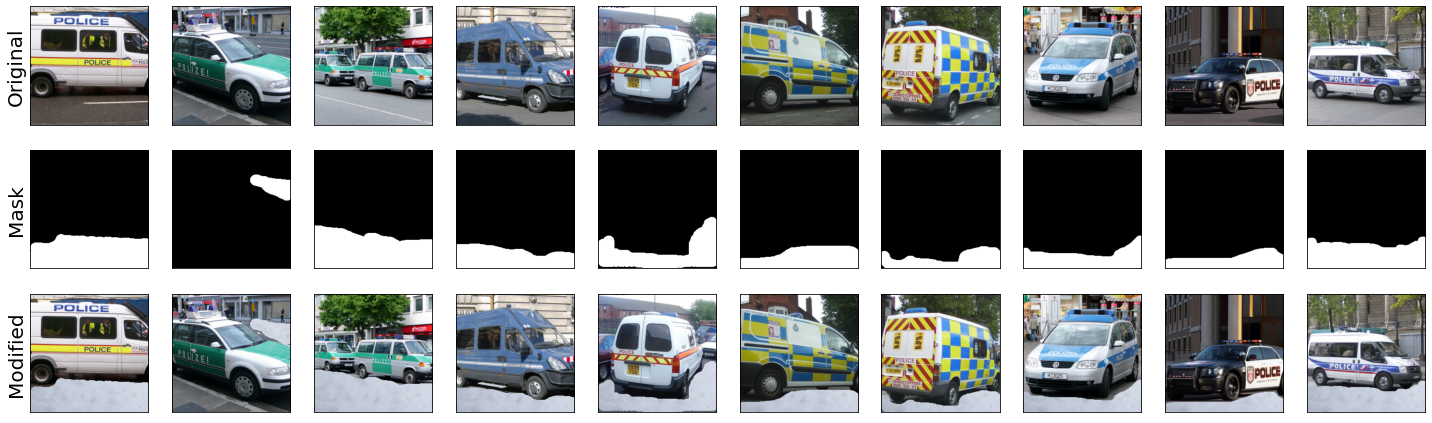

In [ ]:
print("Images and their segmentations")
vh.show_image_row([[im,im2], [cv2.resize(out1.get_image()[:, :, ::-1],(300,200)),cv2.resize(out2.get_image()[:, :, ::-1],(300,200))]], 
                  ['Images', 'Predictions'], fontsize=20)

## Evaluate model performance on test set pre-rewriting

## Perform re-write

In [ ]:
# ntrain, arch, rank, and layernum are included as examples from the original repository, we do not use these fields in our work
train_args = {'ntrain': 1, # Number of exemplars
            'arch': 'vgg16', # Network architecture
            'mode_rewrite': 'editing', # Rewriting method ['editing', 'finetune_local', 'finetune_global']
            'layernum': 12, # Layer to modify
            'nsteps': 20000 if REWRITE_MODE == 'editing' else 400, # Number of rewriting steps  
            'lr': 1e-4, # Learning rate
            'restrict_rank': False, # Whether or not to perform low-rank update
            'nsteps_proj': 10, # Frequency of weight projection
            'rank': 1, # Rank of subspace to project weights
            'use_mask': False # Whether or not to use mask
             }
train_args = Namespace(**train_args)

In [ ]:
 context_model = rh.edit_classifier(train_args, PATH_TO_KEYS, PATH_TO_VALUES)

tensor(0.4664, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 20000/20000 [07:50<00:00, 42.48it/s]


Loss (orig, final): 0.5411404371261597 0.4664229154586792
L2 norm of weight change: 6.536090850830078


tensor(0.4051, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 20000/20000 [02:04<00:00, 161.05it/s]


Loss (orig, final): 0.5541667342185974 0.40511223673820496
L2 norm of weight change: 12.633044242858887


tensor(0.2472, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 20000/20000 [00:36<00:00, 555.28it/s]


Loss (orig, final): 0.6216061115264893 0.24722619354724884
L2 norm of weight change: 20.10072135925293


tensor(0.0519, device='cuda:0', grad_fn=<DivBackward0>): 100%|██████████| 20000/20000 [00:17<00:00, 1170.87it/s]


Loss (orig, final): 0.5550060272216797 0.05194808170199394
L2 norm of weight change: 19.690481185913086


## Evaluate model performance on test set post-rewriting

In [ ]:
compute_metrics()